# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import scipy
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.default_rng(0)

In [3]:
region = [75e3, 150e3, 160e3, 250e3]
height = 1500
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(50, 50), extra_coords=height)]
x, y, z = coordinates
center = [[110e3, 80e3], [200e3, 160e3], [-5e3, -40e3]]
mass = [200 * 4 / 3 * np.pi * np.abs(center[2][0]) ** 3, 400 * 4 / 3 * np.pi * 10e3 ** 3]
base_level = 0
field = hm.point_gravity(coordinates, center, mass, field="g_z") + base_level
delta = 1
xderiv = (
    hm.point_gravity((x + delta, y, z), center, mass, field="g_z")
    - hm.point_gravity((x - delta, y, z), center, mass, field="g_z")
) / 2 * delta
yderiv = (
    hm.point_gravity((x, y + delta, z), center, mass, field="g_z")
    - hm.point_gravity((x, y - delta, z), center, mass, field="g_z")
) / 2 * delta
zderiv = (
    hm.point_gravity((x, y, z + delta), center, mass, field="g_z")
    - hm.point_gravity((x, y, z - delta), center, mass, field="g_z")
) / 2 * delta


field += random.normal(loc=0, scale=0.1, size=field.size)
xderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)

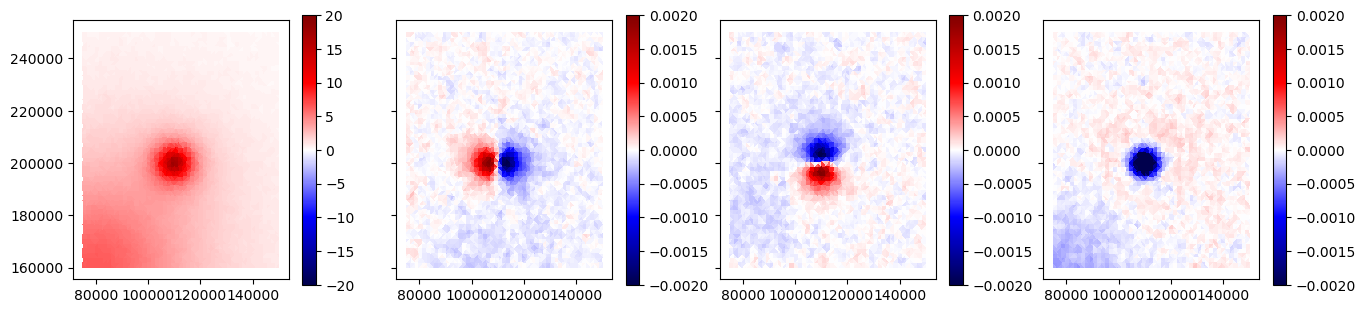

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, field, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
ax.set_aspect("equal")
for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    ax.set_aspect("equal")
    plt.colorbar(tmp)

## Calculate the matrices involved

In [5]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [6]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [49]:
def goal(p, coordinates, field, xderiv, yderiv, zderiv, structural_index):
    x, y, z = coordinates
    xo, yo, zo, baselevel = p
    d = np.hstack([field, xderiv, yderiv, zderiv])
    for i in range(100):        
        f = eulers_equation(x, y, z, d, p, structural_index)
        jacobian = jacobian_data(x, y, z, xo, yo, zo, structural_index)        
        correction = scipy.sparse.linalg.spsolve(jacobian.T @ jacobian, jacobian.T @ f)
        d -= correction             
        if np.sum(np.abs(correction)) < 1e-3:            
            break
    h, dx, dy, dz = np.split(data, 4)
    print(h.size)
    misfit = (
        np.linalg.norm(field - h - base_level)
        + np.linalg.norm(xderiv - dx)
        + np.linalg.norm(yderiv - dy)
        + np.linalg.norm(zderiv - dz)
    )
    return misfit    

In [50]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index):
    region = vd.get_region(coordinates)
    mean_height = np.mean(coordinates[2])
    initial = np.array([
        0.5 * (region[1] + region[0]),
        0.5 * (region[3] + region[2]),
        mean_height - np.abs(0.5 * mean_height),
        0,
    ])
    res = scipy.optimize.minimize(
        goal, 
        initial,
        args=(coordinates, field, xderiv, yderiv, zderiv, structural_index),
        method="Nelder-Mead",
    )
    return res.x

In [51]:
def euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index):
    x, y, z = coordinates
    A = np.stack([xderiv, yderiv, zderiv, np.full_like(field, structural_index)], axis=1)
    d = x * xderiv + y * yderiv + z * zderiv + structural_index * field
    parameters = np.linalg.solve(A.T @ A, A.T @ d)
    return parameters

In [52]:
structural_index = 2
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

/tmp/ipykernel_41505/857162506.py:8: MatrixRankWarning: Matrix is exactly singular
  correction = scipy.sparse.linalg.spsolve(jacobian.T @ jacobian, jacobian.T @ f)


dgstrf info 2
10000
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
dgstrf info 2
10000
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
dgstrf info 2
10000
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
dgstrf info 2
10000
dgstrf info 2
10000
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
dgstrf info 2
10000
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
10000
dgstrf info 2
dgstrf info 2
10000
10000
dgstrf info 2
10000
dgstrf info 2
dgstrf info 2
10000
10000
dgstrf info 2
dgstrf info 2
10000
10000dgstrf info 2

10000
dgstrf info 2
10000
dgstrf info 2
dgstrf info 2
10000
10000
dgstrf info 2


ValueError: operands could not be broadcast together with shapes (2500,) (625,) 

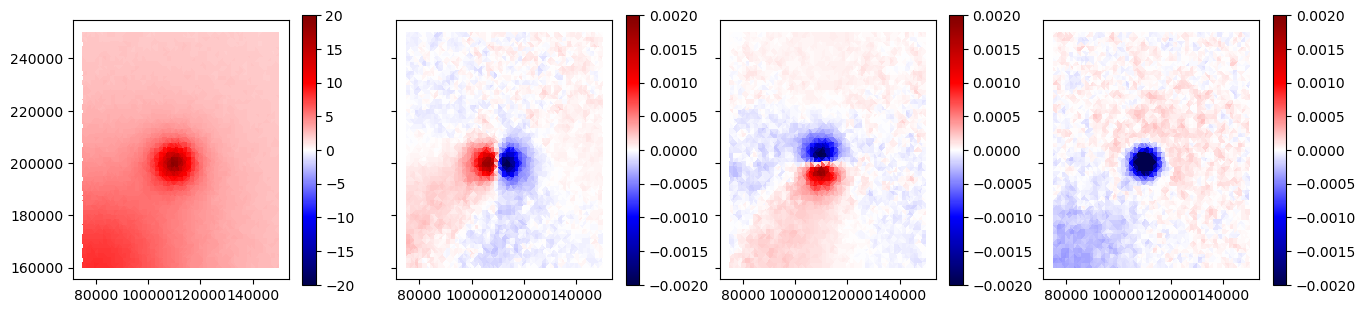

In [152]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, d + p[-1], cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
ax.set_aspect("equal")
for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    ax.set_aspect("equal")
    plt.colorbar(tmp)

In [153]:
structural_index = 1
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

000 | Euler: 6.867e+03 | misfit: 3.056e+01 | merit: 7.801e+03
001 | Euler: 8.789e+02 | misfit: 7.122e-03 | merit: 8.789e+02
002 | Euler: 4.305e+01 | misfit: 7.181e-03 | merit: 4.305e+01
003 | Euler: 5.304e+00 | misfit: 7.310e-03 | merit: 5.304e+00
004 | Euler: 4.015e-02 | misfit: 7.315e-03 | merit: 4.021e-02
005 | Euler: 1.994e-02 | misfit: 7.315e-03 | merit: 1.999e-02
006 | Euler: 2.185e-03 | misfit: 7.315e-03 | merit: 2.238e-03
007 | Euler: 4.513e-04 | misfit: 7.315e-03 | merit: 5.049e-04
008 | Euler: 7.961e-05 | misfit: 7.315e-03 | merit: 1.331e-04
009 | Euler: 1.517e-05 | misfit: 7.315e-03 | merit: 6.869e-05
010 | Euler: 2.821e-06 | misfit: 7.315e-03 | merit: 5.633e-05
011 | Euler: 5.320e-07 | misfit: 7.315e-03 | merit: 5.404e-05
012 | Euler: 9.966e-08 | misfit: 7.315e-03 | merit: 5.361e-05
013 | Euler: 1.874e-08 | misfit: 7.315e-03 | merit: 5.353e-05
014 | Euler: 3.517e-09 | misfit: 7.315e-03 | merit: 5.352e-05
015 | Euler: 6.607e-10 | misfit: 7.315e-03 | merit: 5.351e-05
016 | Eu

In [154]:
structural_index = 3
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

000 | Euler: 1.341e+04 | misfit: 3.056e+01 | merit: 1.434e+04
001 | Euler: 2.309e+03 | misfit: 1.005e-02 | merit: 2.309e+03
002 | Euler: 4.261e+02 | misfit: 8.392e-03 | merit: 4.261e+02
003 | Euler: 1.665e+01 | misfit: 8.677e-03 | merit: 1.665e+01
004 | Euler: 1.698e+00 | misfit: 8.668e-03 | merit: 1.698e+00
005 | Euler: 1.523e-01 | misfit: 8.668e-03 | merit: 1.524e-01
006 | Euler: 3.411e-02 | misfit: 8.668e-03 | merit: 3.418e-02
007 | Euler: 5.041e-03 | misfit: 8.668e-03 | merit: 5.116e-03
008 | Euler: 8.970e-04 | misfit: 8.668e-03 | merit: 9.722e-04
009 | Euler: 1.456e-04 | misfit: 8.668e-03 | merit: 2.208e-04
010 | Euler: 2.429e-05 | misfit: 8.668e-03 | merit: 9.942e-05
011 | Euler: 3.926e-06 | misfit: 8.668e-03 | merit: 7.905e-05
012 | Euler: 6.389e-07 | misfit: 8.668e-03 | merit: 7.577e-05
013 | Euler: 1.025e-07 | misfit: 8.668e-03 | merit: 7.523e-05
014 | Euler: 1.649e-08 | misfit: 8.668e-03 | merit: 7.514e-05
015 | Euler: 2.635e-09 | misfit: 8.668e-03 | merit: 7.513e-05
016 | Eu